In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station

C:\Users\stoyt\AppData\Local\Temp\ipykernel_18456\3117910609.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
table_names = Base.classes.keys()
print(table_names)

['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()
recent_date

('2017-08-23',)

C:\Users\stoyt\AppData\Local\Temp\ipykernel_18456\367865484.py:14: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


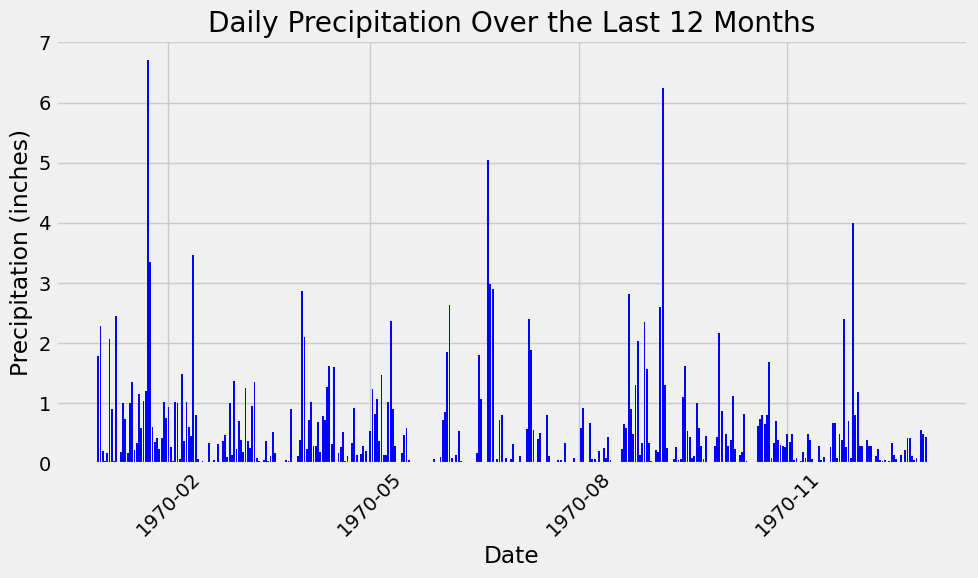

In [10]:
import pandas as pd
from datetime import datetime
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create an engine connected to the database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Reflect the existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# Create a dictionary to store table references
table_references = {table_name: Base.classes[table_name] for table_name in Base.metadata.tables.keys()}

# Example of how to use the table references
Measurement = table_references['measurement']

# Create a session to interact with the database
session = Session(engine)

# Get the most recent date in the database
recent_date = session.query(func.max(Measurement.date)).scalar()
recent_date = datetime.strptime(recent_date, '%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores within the last 12 months
prcp_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= func.date(recent_date, '-1 year')).\
    all()

# Save the query results as a Pandas DataFrame
prcp_data = [{"Date": result.date, "Precipitation": result.prcp} for result in prcp_results]
prcp_df = pd.DataFrame(prcp_data)

# Sort the DataFrame by date
sorted_date = prcp_df.sort_values(by='Date', ascending=True)

# Plot the data using Pandas Plotting with Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(sorted_date['Date'], sorted_date['Precipitation'], color='b')
plt.title('Daily Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.grid(True)

# Set x-axis to show every three months
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = {
    'count': prcp_df['Precipitation'].count(),
    'mean': round(prcp_df['Precipitation'].mean(), 6),
    'std': prcp_df['Precipitation'].std(),
    'min': prcp_df['Precipitation'].min(),
    '25%': prcp_df['Precipitation'].quantile(0.25),
    '50%': prcp_df['Precipitation'].median(),
    '75%': prcp_df['Precipitation'].quantile(0.75),
    'max': prcp_df['Precipitation'].max()
}

summary_df = pd.DataFrame(summary_stats, index=['Precipitation']).T
summary_df.columns = ['Precipitation']

summary_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_count = session.query(Station).distinct().count()
print(total_count)

9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
ordered_station_counts = session.query(
    Measurement.station,
    func.count(Measurement.station).label('count')
).group_by(Measurement.station).order_by(desc('count')).all()

for station, count in ordered_station_counts:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [45]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_count_df = pd.DataFrame(ordered_station_counts, columns=['station', 'count'])

most_active_station = station_count_df.loc[station_count_df['count'].idxmax()]

active_station_stats = session.query(
    func.min(Measurement.tobs).label('min_tobs'),
    func.max(Measurement.tobs).label('max_tobs'),
    func.avg(Measurement.tobs).label('avg_tobs')
).filter(Measurement.station == most_active_station['station']).one()

min_tobs = active_station_stats.min_tobs
max_tobs = active_station_stats.max_tobs
avg_tobs = active_station_stats.avg_tobs

tobs_stats = [(min_tobs, max_tobs, avg_tobs)]

print(most_active_station['station'])
print(tobs_stats)

USC00519281
[(54.0, 85.0, 71.66378066378067)]


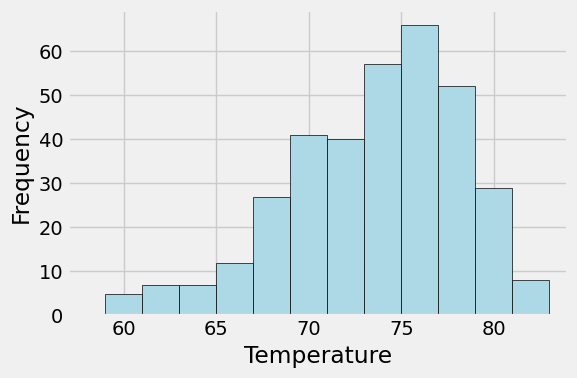

In [56]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sqlalchemy import func

# Assuming session and Measurement are already defined

# Get the most recent date in the database
recent_date_str = session.query(func.max(Measurement.date)).scalar()
recent_date = datetime.strptime(recent_date_str, '%Y-%m-%d')
one_year_ago = recent_date - timedelta(days=365)

# Specific station ID
station_id = 'USC00519281'

# Retrieve temperature observations for the last 12 months for the specific station
tobs_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == station_id).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a DataFrame
tobs_df = pd.DataFrame([{"Date": result.date, "Temperature": result.tobs} for result in tobs_results])

# Calculate statistics for the specific station over the last 12 months
active_station_stats = session.query(
    func.min(Measurement.tobs).label('min_tobs'),
    func.max(Measurement.tobs).label('max_tobs'),
    func.avg(Measurement.tobs).label('avg_tobs')
).filter(Measurement.station == station_id).\
  filter(Measurement.date >= one_year_ago).one()

min_tobs = active_station_stats.min_tobs
max_tobs = active_station_stats.max_tobs
avg_tobs = active_station_stats.avg_tobs

tobs_stats = [(min_tobs, max_tobs, avg_tobs)]

# Plot the histogram
plt.figure(figsize=(6, 4))
plt.hist(tobs_df['Temperature'], bins=12, color='lightblue', edgecolor='black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)

# Set x-axis limits
plt.xlim(57, 84)

plt.tight_layout()
plt.show()


# Close Session

In [16]:
# Close Session
session.close()